## Searching for bouts for a day of alsa recording

In [1]:
import os
import glob
import socket
import logging
import pickle
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal

### Fuck matplotlib, I'm using poltly now
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

logger.info('Running on {}'.format(socket.gethostname()))

2022-07-18 10:10:24,154 root         INFO     Running on pouli


In [2]:
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util.sound import boutsearch as bs
from ceciestunepipe.pipeline import searchbout as sb

### Get the file locations for a session (day) of recordings

In [33]:
reload(et)
sess_par = {'bird': 's_b1360_22',
           'sess': '2022-07-17'}
exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], ephys_software='alsa')

raw_folder = exp_struct['folders']['alsa']
bouts_folder = os.path.join(exp_struct['folders']['derived'], 'bouts_ceciestunepipe')

In [34]:
exp_struct['folders']

{'bird': '/mnt/sphere/speech_bci/raw_data/s_b1360_22',
 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1360_22/2022-07-17',
 'alsa': '/mnt/sphere/speech_bci/raw_data/s_b1360_22/2022-07-17/alsa',
 'kwik': '/experiment/s_b1360_22/alsa/kwik/2022-07-17',
 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1360_22/2022-07-17/alsa',
 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1360_22/2022-07-17/alsa',
 'tmp': '/experiment/tmp/tmp',
 'msort': '/experiment/tmp/s_b1360_22/alsa/msort/2022-07-17',
 'ksort': '/experiment/tmp/s_b1360_22/alsa/ksort/2022-07-17/',
 'sort': '/mnt/sphere/speech_bci/derived_data/s_b1360_22/2022-07-17/alsa/'}

### read a session's bouts pandas
- get the location of the file
- load the pandas pickle
- load the search/spectrogram parameters

In [35]:
pd.__version__

'1.4.2'

In [36]:
reload(sb)
hparams, bpd = sb.read_session_bouts(sess_par['bird'], sess_par['sess'], recording_software='alsa', curated=False)

2022-07-18 10:11:07,162 ceciestunepipe.pipeline.searchbout INFO     Search/bouts file not found in /mnt/sphere/speech_bci/derived_data/s_b1360_22/2022-07-17/alsa/bouts_ceciestunepipe


In [37]:
bpd.head(5)

""


In [38]:
bpd.index.size

0

###### if it wasnt saved (which is a bad mistake), read the sampling rate from the first file in the session

## inspect the bouts and curate them

#### visualize one bout

In [64]:
import plotly.express as px
import plotly.graph_objects as go

from ipywidgets import widgets

In [65]:
def viz_one_bout(df: pd.Series, sub_sample=1):
    # get the power and the spectrogram
    sxx = df['spectrogram'][:, ::sub_sample]
    x = df['waveform'][::sub_sample]
    
    # the trace
    tr_waveform = go.Scatter(y=x)
    figwidg_waveform = go.FigureWidget(data=[tr_waveform],
                                      layout= {'height': 300,'width':1000})

    # the spectrogram
    fig_spectrogram = px.imshow(sxx, 
                                     labels={}, 
                                     color_continuous_scale='Inferno',
                                    aspect='auto')

    fig_spectrogram.update_layout(width=1000, height=300, coloraxis_showscale=False)
    fig_spectrogram.update_xaxes(showticklabels=False)
    fig_spectrogram.update_yaxes(showticklabels=False)
    
    
    figwidg_spectrogram = go.FigureWidget(fig_spectrogram)
    
    display(widgets.VBox([figwidg_waveform,
              figwidg_spectrogram]))
    

#viz_one_bout(bpd.iloc[1])

## use it in a widget


In [66]:
bpd.sort_values('len_ms', ascending=False, inplace=True)
bpd.reset_index(drop=True, inplace=True)

In [67]:
### Create a counter object (count goes 1:1 to DataFrame index)
from traitlets import CInt, link

class Counter(widgets.DOMWidget):
    value = CInt(0)
    value.tag(sync=True)

In [68]:
class VizBout():
    def __init__(self, hparams, bouts_pd):
        self.bout = None
        self.bouts_pd = bouts_pd
        self.bout_series = None
        self.is_bout = None
        self.is_confusing = None
        
        self.bout_counter = None
        self.bout_id = None
        
        self.buttons = {}
        self.m_pick = None
        
        self.audio = None
        
        
        self.fig_waveform = None
        self.fig_spectrogram = None
        
        self.figwidg_waveform = None
        self.figwidg_spectrogram = None
        
        self.fig_width = 2
        self.sub_sample = 10
        
        self.x = None
        self.sxx = None
        self.tr_waveform = None
        
        self.s_f = hparams['sample_rate']
        
        self.init_fig()
        self.init_widget()
        self.show()
        
    def init_fig(self):
        # the trace
        self.tr_waveform = go.Scatter(y=np.zeros(500))
        self.figwidg_waveform = go.FigureWidget(data=[self.tr_waveform],
                                               layout={'width': 1000, 'height':300})
        
        # the spectrogram
        self.fig_spectrogram = px.imshow(np.random.rand(500, 500), 
                                         labels={}, 
                                         color_continuous_scale='Inferno',
                                        aspect='auto')
        
        self.fig_spectrogram.update_layout(width=1000, height=300, coloraxis_showscale=False)
        self.fig_spectrogram.update_xaxes(showticklabels=False)
        self.fig_spectrogram.update_yaxes(showticklabels=False)
        self.figwidg_spectrogram = go.FigureWidget(self.fig_spectrogram)
        
        
    def init_widget(self):
        # declare elements
        # lay them out
        #
        
        self.bout_counter = Counter()
        self.is_bout = widgets.Checkbox(description='is bout')
        self.is_confusing = widgets.Checkbox(description='Not sure or mixed')
        
        self.buttons['Next'] = widgets.Button(description="Next", button_style='info',
                                              icon='plus')   
        self.buttons['Prev'] = widgets.Button(description="Prev", button_style='warning',
                                              icon='minus')
        self.buttons['Check'] = widgets.Button(description="Check", button_style='success', 
                                               icon='check')
        self.buttons['Uncheck'] = widgets.Button(description="Uncheck", button_style='danger',
                                                 icon='wrong')
        
        [b.on_click(self.button_click) for b in self.buttons.values()]
        
        
        left_box = widgets.VBox([self.buttons['Prev'], self.buttons['Uncheck']])
        right_box = widgets.VBox([self.buttons['Next'], self.buttons['Check']])
        button_box = widgets.HBox([left_box, right_box])

        self.m_pick = widgets.IntSlider(value=0, min=0, max=self.bouts_pd.index.size-1,step=1, 
                                        description="Bout candidate index")
        
        
        #self.audio = Audio(data=np.zeros(100), rate=self.s_f)
        
        control_box = widgets.HBox([button_box,
                                  widgets.VBox([self.is_bout, self.is_confusing]),
                                  widgets.VBox([self.m_pick])]
                                  )
        
        link((self.m_pick, 'value'), (self.bout_counter, 'value'))

        self.update_bout()
        
        self.is_bout.observe(self.bout_checked, names='value')
        self.is_confusing.observe(self.confusing_checked, names='value')
        self.m_pick.observe(self.slider_change, names='value')
        
        all_containers = widgets.VBox([control_box, 
                                       self.figwidg_waveform, self.figwidg_spectrogram])
        display(all_containers)
#         display(button_box)
#         display(self.m_pick)
#         display(self.is_bout)
#         display(self.fig)
        
    def button_click(self, button):        
        self.bout_id = self.bout_counter.value
        curr_bout = self.bout_counter
        
        if button.description == 'Next':
            curr_bout.value += 1
        elif button.description == 'Prev':
            curr_bout.value -= 1
        elif button.description == 'Check':
            self.bouts_pd.loc[self.bout_id, 'bout_check'] = True
            self.bouts_pd.loc[self.bout_id, 'confusing'] = False
            curr_bout.value += 1
        elif button.description == 'Uncheck':
            self.bouts_pd.loc[self.bout_id, 'bout_check'] = False
            self.bouts_pd.loc[self.bout_id, 'confusing'] = False
            curr_bout.value += 1
        
        # handle the edges of the counter
        if curr_bout.value > self.m_pick.max:
            curr_bout.value = 0
            
        if curr_bout.value < self.m_pick.min:
            curr_bout.value = self.m_pick.max
    
    def slider_change(self, change):
        #logger.info('slider changed')
        #self.bout_counter = change.new
        #clear_output(True)
        self.update_bout()
        self.show()
            
    def bout_checked(self, bc):
#         print "bout checked"
#         print bc['new']
#         print self.motiff
        self.bouts_pd.loc[self.bout_id, 'bout_check'] = bc['new']
    
    def confusing_checked(self, bc):
#         print "bout checked"
#         print bc['new']
#         print self.motiff
        self.bouts_pd.loc[self.bout_id, 'confusing'] = bc['new']
    
    def update_bout(self):
        self.bout_id = self.bout_counter.value
        self.bout_series = self.bouts_pd.iloc[self.bout_id]
        
        self.is_bout.value = bool(self.bout_series['bout_check'])
        self.is_confusing.value = bool(self.bout_series['confusing'])
        
        self.x = self.bout_series['waveform'][::self.sub_sample]
        self.sxx = self.bout_series['spectrogram'][::self.sub_sample]
        
        #self.audio = Audio(data=self.x.flatten(), rate=self.s_f)
        
    def show(self):
        #self.fig.clf()
        #self.init_fig()
        # update
#         self.update_bout()
        #plot
        #logger.info('showing')
        
        # Show the figures
        with self.figwidg_waveform.batch_update():
            self.figwidg_waveform.data[0].y = self.x
            self.figwidg_waveform.data[0].x = np.arange(self.x.size) * self.sub_sample / self.s_f 
            
        with self.figwidg_spectrogram.batch_update():
            self.figwidg_spectrogram.data[0].z = np.sqrt(self.sxx[::-1])
            
        

viz_bout = VizBout(hparams, bpd)

In [69]:
raise KeyboardInterrupt

KeyboardInterrupt: 

In [ ]:
np.where((viz_bout.bouts_pd['bout_check']==True) & (viz_bout.bouts_pd['confusing']==False) & (bpd['len_ms']>10000))[0].size

### save it

In [156]:
### get the curated file path
##save to the curated file path
bouts_curated_file_path = os.path.join(bouts_folder, hparams['bout_curated_file'])

os.makedirs(bouts_folder, exist_ok=True, mode=0o777)

viz_bout.bouts_pd.to_pickle(bouts_curated_file_path)
logger.info('saved curated bout pandas t
            o pickle {}'.format(bouts_curated_file_path))

SyntaxError: EOL while scanning string literal (429530480.py, line 8)

### Curated bouts longer than 10 seconds

2022-07-05 09:31:49,939 root         INFO     Number of bouts: 14
2022-07-05 09:31:49,939 root         INFO     Number of bouts: 14
2022-07-05 09:31:49,939 root         INFO     Number of bouts: 14
2022-07-05 09:31:49,939 root         INFO     Number of bouts: 14
2022-07-05 09:31:49,939 root         INFO     Number of bouts: 14
2022-07-05 09:31:49,939 root         INFO     Number of bouts: 14
2022-07-05 09:31:49,943 root         INFO     Length of all bouts (minutes): 4.36225
2022-07-05 09:31:49,943 root         INFO     Length of all bouts (minutes): 4.36225
2022-07-05 09:31:49,943 root         INFO     Length of all bouts (minutes): 4.36225
2022-07-05 09:31:49,943 root         INFO     Length of all bouts (minutes): 4.36225
2022-07-05 09:31:49,943 root         INFO     Length of all bouts (minutes): 4.36225
2022-07-05 09:31:49,943 root         INFO     Length of all bouts (minutes): 4.36225


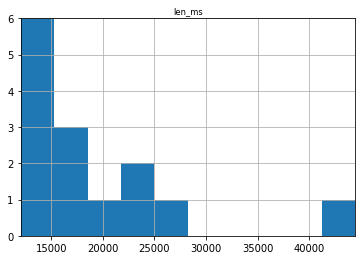

In [99]:
def sess_bout_summary(bout_pd: pd.DataFrame, ax_dict: dict=None, bouts_type='curated', min_len_ms=10000) -> pd.DataFrame:
    ## make and plot a summary of the bird's bout.
    # get lengths of the bouts
    # get estimate timestamps of bouts
    # plot histogram length of bouts
    # histogram of time of bouts
    bout_sel = (bout_pd['valid']==True) & (bout_pd['len_ms'] > min_len_ms);
    if bouts_type=='curated':
        bout_sel = bout_sel & (bout_pd['bout_check']==True) & (bout_pd['confusing']==False);
    
    # len/time? (when do they sing the longest?)
    logger.info('Number of bouts: {}'.format(bout_pd.loc[bout_sel].index.size))
    logger.info('Length of all bouts (minutes): {}'.format(bout_pd.loc[bout_sel, 'len_ms'].values.sum()/60000))
    
    if ax_dict is None:
        bout_pd.loc[bout_sel].hist(column='len_ms')
    return bout_pd

bpd = sess_bout_summary(bpd)

In [ ]:
viz_bout.bouts_pd['file'][0]

In [ ]:
viz_bout.bouts_pd[viz_bout.bouts_pd['bout_check']==True]['file'].values

In [ ]:
viz_bout.bouts_pd.head(1)